In [453]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from UnFaIR import *
import scipy as sp
import pickle
import time

In [454]:
## Get Law Dome

Law_Dome = pd.read_csv('./Conc_fit_data/law2006.txt',index_col=0,skiprows=183,nrows=2188-184,delim_whitespace=True,usecols=[0,3,5,8],names=['Year','CH4','CO2','N2O'])

# Get NOAA atmospheric observations

obsv_concs = pd.read_csv('./Conc_fit_data/NOAA_Conc_data.csv',skiprows=4,header=None,index_col=0).dropna().iloc[:,:3].values
obsv_concs = pd.DataFrame(data=obsv_concs,index = np.arange(1979,2018),columns=['CO2','CH4','N2O'])

# Get CMIP6 concs (some harmonization of Law Dome and atmospheric observations:

CMIP6_concs = pd.read_csv('./CMIP_input_ems/Supplementary_Table_UoM_GHGConcentrations-1-1-0_annualmeans_v23March2017.csv',skiprows=21,index_col=0)

# Get HadCRUT4 ensemble as a temperature response... 


HadCRUT_ensemble = pd.read_csv('./Conc_fit_data/HadCRUT4_annual_obsv/HadCRUT.4.6.0.0.annual_ns_avg.1.txt',index_col=0,delim_whitespace=True,usecols=[0,1],names=['Year',1])
for i in np.arange(2,101):
    HadCRUT_ensemble[i] = pd.read_csv('./Conc_fit_data/HadCRUT4_annual_obsv/HadCRUT.4.6.0.0.annual_ns_avg.'+str(i)+'.txt',index_col=0,delim_whitespace=True,usecols=[0,1],names=['Year',i])
    
HadCRUT_ensemble = HadCRUT_ensemble - HadCRUT_ensemble.loc[1850:1900].mean() + 0.007

HadCRUT_2010 = sp.stats.norm.fit(HadCRUT_ensemble.loc[2010])

In [455]:
## Get my best estimate emission series generated by the emission script.

emissions = pd.read_csv('./Best_estimate_emissions_for_UnFaIR.csv',index_col=0)

In [456]:
## Get some RCP emisisons / concentrations / forcings

RCP = '85'
RCP_E = pd.read_csv('./RCP_data/RCP'+RCP+'_EMISSIONS.csv',skiprows=36,index_col=0)
RCP_C = pd.read_csv('./RCP_data/RCP'+RCP+'_MIDYEAR_CONCENTRATIONS.csv',skiprows=37,index_col=0)
RCP_forc = pd.read_csv('./Conc_fit_data/RCP'+RCP+'_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)
otherforc = RCP_forc.TOTAL_INCLVOLCANIC_RF.loc[:2012].values - RCP_forc.CO2CH4N2O_RF.loc[:2012].values

In [547]:
## Get some temperature / CH4 scenarios

SR15_DB = pd.read_csv('./Conc_fit_data/IAMC_T_RF_E_C.csv')
SR15_DB = SR15_DB.set_index(SR15_DB['Model'] + SR15_DB['Scenario'])
SR15_DB.columns = list(SR15_DB.columns)[:5] + list(range(2010,2101))

SR15_TEMPS = SR15_DB.loc[SR15_DB['Variable'] == 'Temperature|Global Mean']
SR15_CH4 = SR15_DB.loc[SR15_DB['Variable'] == 'Concentration|CH4']
common_index = set.intersection(set(SR15_CH4.index),set(SR15_TEMPS.index))

SR15_TEMPS = SR15_TEMPS.loc[common_index]
SR15_CH4 = SR15_CH4.loc[common_index]

SR15_TEMPS = SR15_TEMPS.iloc[:,5:].apply(pd.to_numeric).replace(to_replace=0.0,value=np.nan).interpolate(axis=1).sort_index()
SR15_CH4 = SR15_CH4.iloc[:,5:].apply(pd.to_numeric).replace(to_replace=0.0,value=np.nan).interpolate(axis=1).sort_index()

SR15_CH4 = SR15_CH4.loc[(SR15_CH4[2010]>1750)&(SR15_CH4[2010]<1850)]
SR15_TEMPS = SR15_TEMPS.loc[SR15_CH4.index]

In [582]:
## Let's try doing prather for a range of physically sensible concs / temps, rather than a specific scenario:

def Jacobson05(T):
    return 6.112 * np.exp( 6816 * ( 1 / 273.15 - 1 / T ) + 5.1309 * np.log( 273.15 / T ) )

scen_choice = np.random.choice(SR15_TEMPS.index)
Temp_range = SR15_TEMPS.values   
Temp_2010 = Temp_range[:,0][:,np.newaxis]
Atmos_temp_range = 251.9 + 0.94 * ( Temp_range - Temp_2010 )
Conc_range = SR15_CH4.values
Conc_2010 = Conc_range[:,0][:,np.newaxis]
Sat_p_range = Jacobson05(Atmos_temp_range)
q_range = 2.45 * ( 1 + 1.5 * (Sat_p_range - Jacobson05(251.9)) / Jacobson05(251.9) )

N=5000

params = np.zeros((N,2))

for mcn in np.arange(N):

    OH_tau = np.random.normal(11.2,1.3)
    oth_tau = (1/np.random.normal(200,100)+1/np.random.normal(120,24)+1/np.random.normal(150,50))**(-1)#(1/200+1/120+1/150)**(-1)

    tau_2010 = 1/(1/OH_tau + 1/oth_tau)

    alph_T = np.random.normal(-3.,0.8)
    alph_q = np.random.normal(-0.32,0.03)
    alph_CH4 = np.random.normal(0.31,0.04)

    PR_alpha = (Atmos_temp_range/251.9)**alph_T * (Conc_range/Conc_2010)**alph_CH4 * (q_range / 2.45)**alph_q

    eff_alpha = (1/tau_2010) * (1/(PR_alpha*OH_tau) + 1/oth_tau)**(-1)

    emis2conc = 28.97/(5.148*16)

    g1 = 9.15 * (1- (1+100/9.15)*np.exp(-100/9.15))
    g0 = (np.sinh(9.15*(1-np.exp(-100/9.15))/g1))**(-1)

    def fit_to_prather_theory(x):

        ## Here, 700 is my approx preindustrial concentration
        r0 = np.arcsinh(1/g0)*g1 - x[0] * (Conc_2010-700) / emis2conc + x[1] * Temp_2010

        my_alpha = g0 * np.sinh((r0 + x[0] * (Conc_range-700) / emis2conc + x[1] * (Temp_range))/g1)

        return np.sum((my_alpha - eff_alpha)**2)

    params[mcn] = sp.optimize.minimize(fit_to_prather_theory,[0.00025,-0.3],method='Nelder-Mead')['x']


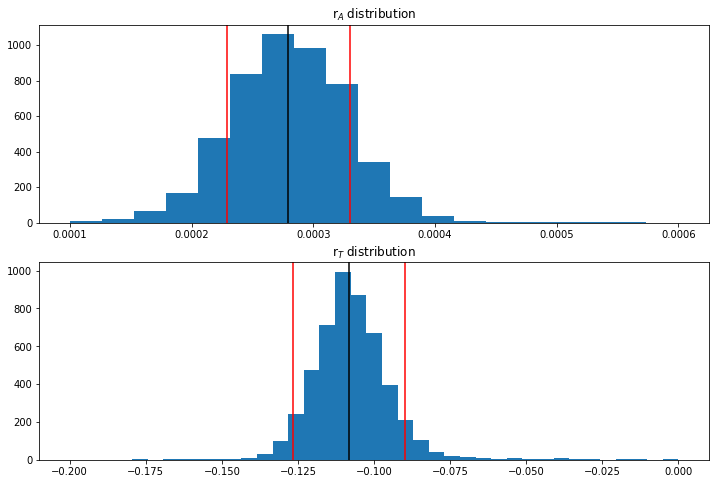

In [583]:
fig,ax=plt.subplots(2,figsize=(12,8))
ax[0].hist(params[:,0],bins=np.linspace(0.0001,0.0006,20))
ax[1].hist(params[:,1],bins=np.linspace(-0.2,-0.0,40))
ax[0].set_title('r$_A$ distribution')
ax[1].set_title('r$_T$ distribution')

rA_norm = sp.stats.norm.fit(params[:,0][(params[:,0]<0.0006) * (params[:,0]>0.000)])
rT_norm = sp.stats.norm.fit(params[:,1][(params[:,1]<0.0) * (params[:,1]>-0.5)])
ax[0].axvline(rA_norm[0],color='k')
ax[0].axvline(rA_norm[0]+rA_norm[1],color='r')
ax[0].axvline(rA_norm[0]-rA_norm[1],color='r')
ax[1].axvline(rT_norm[0],color='k')
ax[1].axvline(rT_norm[0]+rT_norm[1],color='r')
ax[1].axvline(rT_norm[0]-rT_norm[1],color='r')

CH4_params = {'rA':rA_norm, 'rT':rT_norm}

In [584]:
Conc_range = np.linspace(273.,600,100)

N = 10000

params = np.zeros(N)

for mcn in np.arange(N):
    
    Conc_2010 = 321.
    
    alph_N2O = np.random.normal(-0.065,0.01)
    
    tau_2010 = np.random.normal(116,9)
    
    alpha_PR = (Conc_range/Conc_2010)**alph_N2O
    
    emis2conc = 28.97/(5.148*28)

    g1 = 116 * (1 - (1+100/116)*np.exp(-100/116))
    g0 = (np.sinh(116*(1-np.exp(-100/116))/g1))**(-1)
    
    def fit_to_prather_theory_N2O(x):
        
        r0 = np.arcsinh(1/g0)*g1 - x * (Conc_2010-273.) / emis2conc

        my_alpha = g0 * np.sinh((r0 + x * (Conc_range-273.) / emis2conc) /g1)

        return np.sum((my_alpha - alpha_PR)**2)
    
    params[mcn] = sp.optimize.minimize(fit_to_prather_theory_N2O,-0.0009,method='Nelder-Mead')['x']

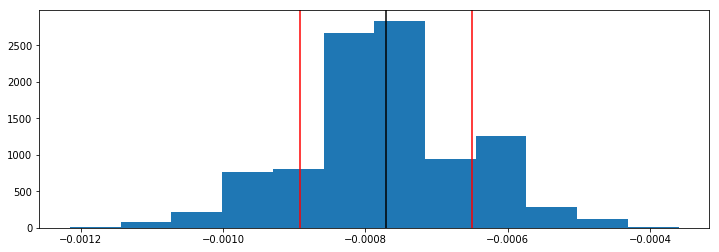

In [585]:
rA_norm = sp.stats.norm.fit(params)

fig,ax=plt.subplots(figsize=(12,4))
ax.hist(params,bins=12)
ax.axvline(rA_norm[0],color='k')
ax.axvline(rA_norm[0]+rA_norm[1],color='r')
ax.axvline(rA_norm[0]-rA_norm[1],color='r')

N2O_params = {'rA':rA_norm}

## Fitting rA and rT with mAtHS

- linearize sinh with a small dx expansion

- sinh(x + dx) ~= (1 + dx cosh(x)) sinh(x)

- If we do this, baselining around sinh(x) = 1; ie. 2010 as in Prather, we should be able to get a pretty nice distribution!

In [743]:
## We'll do this procedure, checking that the small approximation is justified for the max concs / temps we would see

## generate some alphas:
g1 = 9.15 * (1- (1+100/9.15)*np.exp(-100/9.15))

emis2conc = 28.97/(5.148*16)

scen_choice = np.random.choice(SR15_TEMPS.index)
Temp_range = np.linspace(-1.1,6,50)  
Atmos_temp_range = 251.9 + 0.94 * ( Temp_range )
Conc_range = np.linspace(1500,4000,50)
Conc_2010 = 1800
Sat_p_range = Jacobson05(Atmos_temp_range)
q_range = 2.45 * ( 1 + 1.5 * (Sat_p_range - Jacobson05(251.9)) / Jacobson05(251.9) )

N=50000

params = np.zeros((N,2,50))

for mcn in np.arange(N):

    OH_tau = np.random.normal(11.2,1.3)
    oth_tau = (1/np.random.normal(200,100)+1/np.random.normal(120,24)+1/np.random.normal(150,50))**(-1)#(1/200+1/120+1/150)**(-1)

    tau_2010 = 1/(1/OH_tau + 1/oth_tau)

    alph_T = np.random.normal(-3.,0.8)
    alph_q = np.random.normal(-0.32,0.03)
    alph_CH4 = np.random.normal(0.31,0.04)

    PR_alpha = (Atmos_temp_range/251.9)**alph_T * (q_range / 2.45)**alph_q

    eff_alpha = (1/tau_2010) * (1/(PR_alpha*OH_tau) + 1/oth_tau)**(-1)
    
    rT = (g1/Temp_range)*(eff_alpha-1)/np.cosh(np.arcsinh(1))
    
    PR_alpha = (Conc_range/Conc_2010)**alph_CH4

    eff_alpha = (1/tau_2010) * (1/(PR_alpha*OH_tau) + 1/oth_tau)**(-1)
    
    rA = (g1*emis2conc/(Conc_range-Conc_2010))*(eff_alpha-1)/np.cosh(np.arcsinh(1))

    params[mcn] = [rA,rT]
    
rA_CH4_dist = params[:,0].flatten()
rT_CH4_dist = params[:,1].flatten()

rA : 0.000263 [0.0002128 , 0.0003221]


rT : -0.24 [-0.274 , -0.21]


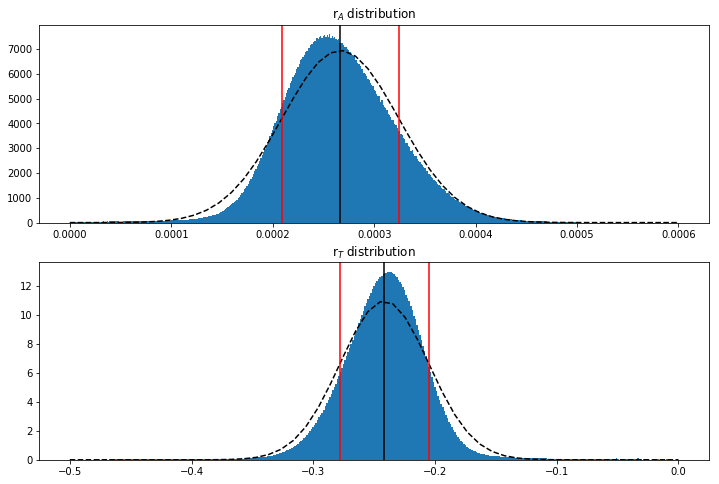

In [744]:
fig,ax=plt.subplots(2,figsize=(12,8))
ax[0].hist(params[:,0].flatten(),bins=np.linspace(0.0000,0.0005,400),density=True)
ax[1].hist(params[:,1].flatten(),bins=np.linspace(-0.5,-0.0,400),density=True)
ax[0].set_title('r$_A$ distribution')
ax[1].set_title('r$_T$ distribution')

rA_norm = sp.stats.norm.fit(params[:,0][(params[:,0]<0.0006) * (params[:,0]>0.000)])
rT_norm = sp.stats.norm.fit(params[:,1][(params[:,1]<0.0) * (params[:,1]>-0.5)])
ax[0].plot(np.linspace(0.0,0.0006),sp.stats.norm.pdf(np.linspace(0,0.0006),rA_norm[0],rA_norm[1]),'k--')
ax[1].plot(np.linspace(-0.5,0),sp.stats.norm.pdf(np.linspace(-0.5,0),rT_norm[0],rT_norm[1]),'k--')
ax[0].axvline(rA_norm[0],color='k')
ax[0].axvline(rA_norm[0]+rA_norm[1],color='r')
ax[0].axvline(rA_norm[0]-rA_norm[1],color='r')
ax[1].axvline(rT_norm[0],color='k')
ax[1].axvline(rT_norm[0]+rT_norm[1],color='r')
ax[1].axvline(rT_norm[0]-rT_norm[1],color='r')

print( 'rA : ' + str(round(np.median(params[:,0]),6)) + \
      ' [' + str(round(np.percentile(params[:,0],16),7)) + ' , ' + \
     str(round(np.percentile(params[:,0],84),7)) + ']' )
print('\n')
print( 'rT : ' + str(round(np.median(params[:,1]),2)) + \
      ' [' + str(round(np.percentile(params[:,1],16),3)) + ' , ' + \
     str(round(np.percentile(params[:,1],84),3)) + ']' )

In [745]:
## We'll do this procedure, checking that the small approximation is justified for the max concs / temps we would see

## generate some alphas:

g1 = 116 * (1- (1+100/116)*np.exp(-100/116))

emis2conc = 28.97/(5.148*28)

Conc_range = np.linspace(270,500,50)
Conc_2010 = 321


N=50000

params = np.zeros((N,1,50))

for mcn in np.arange(N):

    tau_2010 = np.random.normal(116,9)

    alph_N2O = np.random.normal(-0.065,0.01)

    eff_alpha = (Conc_range/Conc_2010)**alph_N2O
    
    rA = (g1*emis2conc/(Conc_range-Conc_2010))*(eff_alpha-1)/np.cosh(np.arcsinh(1))

    params[mcn] = [rA]
    
rA_N2O_dist = params.flatten()

rA : -0.000648 [-0.0007745 , -0.0005373]


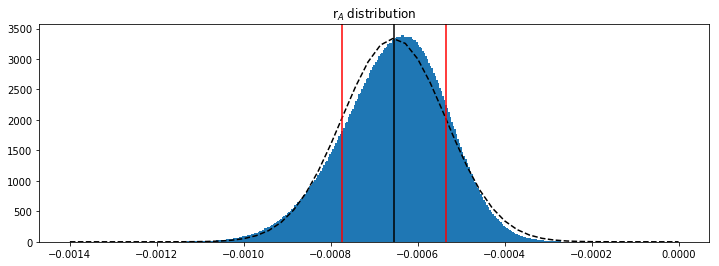

In [746]:
fig,ax=plt.subplots(1,figsize=(12,4))
ax.hist(params[:,0].flatten(),bins=np.linspace(-0.0014,0.000,400),density=True)
ax.set_title('r$_A$ distribution')

rA_norm = sp.stats.norm.fit(params[:,0][(params[:,0]<0) * (params[:,0]>-0.0014)])
ax.plot(np.linspace(-0.0014,0),sp.stats.norm.pdf(np.linspace(-0.0014,0),rA_norm[0],rA_norm[1]),'k--')
ax.axvline(rA_norm[0],color='k')
ax.axvline(rA_norm[0]+rA_norm[1],color='r')
ax.axvline(rA_norm[0]-rA_norm[1],color='r')

print( 'rA : ' + str(round(np.median(params[:,0]),6)) + \
      ' [' + str(round(np.percentile(params[:,0],16),7)) + ' , ' + \
     str(round(np.percentile(params[:,0],84),7)) + ']' )

In [586]:
## Now just need a justifiable method for fitting r0, PI_conc. 

# - minimize lstsq + PD (equal weight) & monte carlo?

# - maybe a monte carlo of rA,rT,temps,emissions (uncert from prather fractional?) would get us something?
# - might have to set a less than machine precision tolerance for the fit to make the thing runnable.
# - 

# - OR constrain r0, PI_conc using PI natural emissions from Prather? This seems to give poor results.
# -> Maybe we don't fit using nat ems BUT we calculate them and give them an uncertainty to check consistency with prather?


In [747]:
## We need a reasonable temperature response to fit to:

## Get a temp response
forcings = pd.read_csv('./Conc_fit_data/Annualforcings_Mar2014_GHGrevised.txt',skiprows=3,sep='\t',index_col=0)
empty_ems = pd.DataFrame(index=forcings.index,columns=['CO2','CH4','N2O']).fillna(0.)
T_ant = UnFaIR(emissions_in=empty_ems,F_ext=forcings.Anthrototal.values)['T']
T_nat = UnFaIR(emissions_in=empty_ems,F_ext=(forcings.Total.values - forcings.Anthrototal.values))['T']

## Get the other temp datasets:

NOAA_T = pd.read_csv('./Conc_fit_data/1880-2019_NOAA_1.csv',skiprows=4,index_col=0)
GISS_T = pd.read_csv('./Conc_fit_data/GLB.Ts+dSST.csv',skiprows=1,index_col=0,usecols=['Year','J-D'])
BERKELEY_T = pd.read_csv('./Conc_fit_data/Berkeley_Earth_Land_and_Ocean_complete_csv_sea_ice_air.csv',index_col=0)
CW_T = pd.read_csv('./Conc_fit_data/had4_krig_annual_v2_0_0.txt',index_col=0,delim_whitespace=True,names=['Year','Anom'],usecols=[0,1])
HadCRUT_ensemble = pd.read_csv('./Conc_fit_data/HadCRUT4_annual_obsv/HadCRUT.4.6.0.0.annual_ns_avg.1.txt',index_col=0,delim_whitespace=True,usecols=[0,1],names=['Year',1])
for i in np.arange(2,101):
    HadCRUT_ensemble[i] = pd.read_csv('./Conc_fit_data/HadCRUT4_annual_obsv/HadCRUT.4.6.0.0.annual_ns_avg.'+str(i)+'.txt',index_col=0,delim_whitespace=True,usecols=[0,1],names=['Year',i])

baseline_start = 1880
baseline_end = 1901
    
BERKELEY_T = BERKELEY_T.rolling(12).mean().iloc[11::12,1]
CW_T = CW_T['Anom']
GISS_T = GISS_T['J-D'].iloc[:-1].apply(pd.to_numeric)
NOAA_T = NOAA_T['Value']

TEMP_DATASETS = pd.DataFrame([NOAA_T,GISS_T,BERKELEY_T,CW_T,HadCRUT_ensemble.mean(axis=1)],index=['NOAA','GISS','BERKELEY','CW','HadCRUT']).transpose()
HC_UNCERT = (HadCRUT_ensemble.transpose() - HadCRUT_ensemble.mean(axis=1)).transpose()
#HC_UNCERT.plot(legend=None)

#TEMP_DATASETS.plot()

TEMP_DATASETS -= TEMP_DATASETS.loc[1880:1920].mean()
TEMP_DATASETS['Mean'] = TEMP_DATASETS.mean(axis=1)

In [748]:
import statsmodels.api as sm

X = pd.DataFrame([T_ant.Total,T_nat.Total],index=['ANT','NAT']).transpose()
X = sm.add_constant(X)
T_responses = pd.DataFrame(index=X.index)

for i in np.arange(1,101):

    y = TEMP_DATASETS.Mean + (HC_UNCERT - HC_UNCERT.loc[1880:1920].mean())[i]

    ols_fit = sm.OLS(y.loc[X.index].dropna(),X.loc[y.index].dropna()).fit()
    
    T_responses[i] = (ols_fit.params[['ANT','NAT']] * X[['ANT','NAT']]).sum(axis=1)
    
## And we now have an uncertainty in our temperature response!

T_responses -= T_responses.loc[1765]

/home/nleach/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()


In [749]:
def fit_r0_PI_conc(x,species,params,T_response,emissions):
    
    params.loc[['r0','PI_conc'],species] = [x[0],x[1]]
        
    model_run = fit_gas_cycles(emissions,T_response,params)[species]
    
    return np.sum((model_run.loc[1850:].values.flatten() - CMIP6_concs.loc[1850:2012,species].values.flatten())**2 / CMIP6_concs.loc[1850:2012,species].values.flatten()**2) + \
           163 * (model_run.loc[2012] - CMIP6_concs.loc[2012,species])**2 / CMIP6_concs.loc[2012,species]**2

In [750]:
gas_params = default_gas_params()

emissions_fit = emissions.copy()

N = 1000

r0_dist_CH4 = np.zeros(N)
PI_conc_dist_CH4 = np.zeros(N)
r0_dist_N2O = np.zeros(N)
PI_conc_dist_N2O = np.zeros(N)

for mcn in np.arange(N):
    
    if mcn%50 == 0:
        print(mcn)
    
    T_response = T_responses[np.random.choice(np.arange(1,101))].loc[1765:2012]
    
    emissions_fit['CH4'] = emissions['CH4'] * np.random.normal(1,45/352) # error from prather
    
    emissions_fit['N2O'] = emissions['N2O'] * np.random.normal(1,1.3/6.6)
    
    gas_params.loc['rA','CH4'] = np.random.choice(rA_CH4_dist)
    gas_params.loc['rT','CH4'] = np.random.choice(rT_CH4_dist)
    gas_params.loc['rA','N2O'] = np.random.choice(rA_N2O_dist)
    
    fit_params_CH4 = sp.optimize.minimize(fit_r0_PI_conc,[9,700],args=('CH4',gas_params,T_response,emissions_fit),\
                                     method='COBYLA',tol=1e-2)
    
    fit_params_N2O = sp.optimize.minimize(fit_r0_PI_conc,[65,270],args=('N2O',gas_params,T_response,emissions_fit),\
                                     method='COBYLA',tol=1e-2)
    
    r0_dist_CH4[mcn] = fit_params_CH4['x'][0]
    PI_conc_dist_CH4[mcn] = fit_params_CH4['x'][1]
    r0_dist_N2O[mcn] = fit_params_N2O['x'][0]
    PI_conc_dist_N2O[mcn] = fit_params_N2O['x'][1]

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


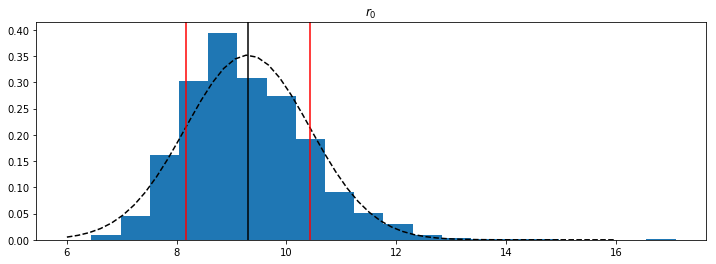

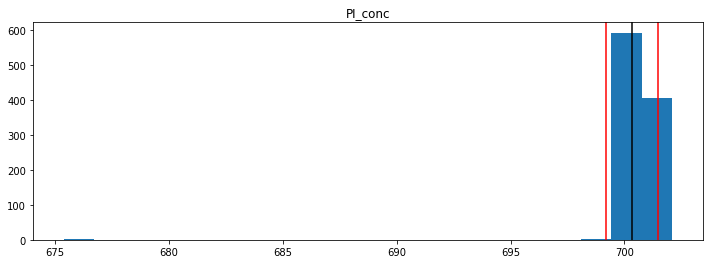

In [756]:
## CH4 ##

r0_norm = sp.stats.norm.fit(r0_dist_CH4)
fig,ax=plt.subplots(figsize=(12,4))
ax.hist(r0_dist_CH4,bins=20,density=True)
ax.plot(np.linspace(6,16),sp.stats.norm.pdf(np.linspace(6,16),r0_norm[0],r0_norm[1]),'k--')
ax.axvline(r0_norm[0],color='k')
ax.axvline(r0_norm[0]+r0_norm[1],color='r')
ax.axvline(r0_norm[0]-r0_norm[1],color='r')
ax.set_title('$r_0$')

CH4_params['r0'] = r0_norm

PI_norm = sp.stats.norm.fit(PI_conc_dist_CH4)
fig,ax=plt.subplots(figsize=(12,4))
ax.hist(PI_conc_dist_CH4,bins=20)
ax.axvline(PI_norm[0],color='k')
ax.axvline(PI_norm[0]+r0_norm[1],color='r')
ax.axvline(PI_norm[0]-r0_norm[1],color='r')
ax.set_title('PI_conc')

CH4_params['PI_conc'] = PI_norm

60.95587321821874 276.01116112222235


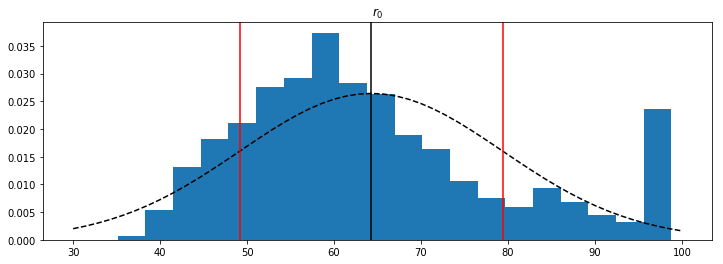

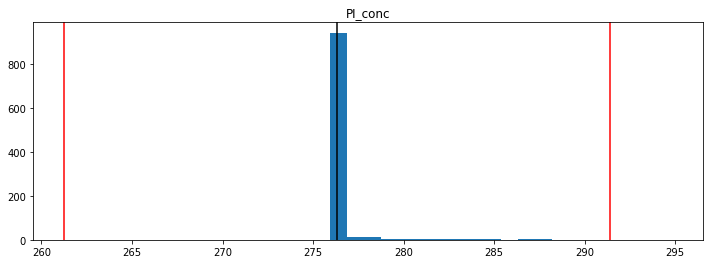

In [757]:
## N2O ##

r0_norm = sp.stats.norm.fit(r0_dist_N2O)
fig,ax=plt.subplots(figsize=(12,4))
ax.hist(r0_dist_N2O,bins=20,density=True)
ax.plot(np.linspace(30,100),sp.stats.norm.pdf(np.linspace(30,100),r0_norm[0],r0_norm[1]),'k--')
ax.axvline(r0_norm[0],color='k')
ax.axvline(r0_norm[0]+r0_norm[1],color='r')
ax.axvline(r0_norm[0]-r0_norm[1],color='r')
ax.set_title('$r_0$')

N2O_params['r0'] = r0_norm

PI_norm = sp.stats.norm.fit(PI_conc_dist_N2O)
fig,ax=plt.subplots(figsize=(12,4))
ax.hist(PI_conc_dist_N2O,bins=20)
ax.axvline(PI_norm[0],color='k')
ax.axvline(PI_norm[0]+r0_norm[1],color='r')
ax.axvline(PI_norm[0]-r0_norm[1],color='r')
ax.set_title('PI_conc')

N2O_params['PI_conc'] = PI_norm


print(np.median(r0_dist_N2O),np.median(PI_conc_dist_N2O))

## The CH4 / N2O Parameters & Errors:

In [761]:
## Previous parameters
print('CH4:')
print( 'r0 : ' + str(round(np.median(r0_dist_CH4),2)) + \
      ' [' + str(round(np.percentile(r0_dist_CH4,16),4)) + ' , ' + \
     str(round(np.percentile(r0_dist_CH4,84),4)) + ']'  + ' - ' + \
     str(round(100*(1-np.percentile(r0_dist_CH4,16)/np.median(r0_dist_CH4)),2)) + '%')
print('\n')
print( 'rA : ' + str(round(np.median(rA_CH4_dist[:]),6)) + \
      ' [' + str(round(np.percentile(rA_CH4_dist[:],16),7)) + ' , ' + \
     str(round(np.percentile(rA_CH4_dist[:],84),7)) + ']' + ' - ' + \
     str(round(100*(1-np.percentile(rA_CH4_dist,16)/np.median(rA_CH4_dist)),2)) + '%')
print('\n')
print( 'rT : ' + str(round(np.median(rT_CH4_dist[:]),3)) + \
      ' [' + str(round(np.percentile(rT_CH4_dist[:],16),4)) + ' , ' + \
     str(round(np.percentile(rT_CH4_dist[:],84),4)) + ']' + ' - ' + \
     str(round(100*(1-np.percentile(rT_CH4_dist,16)/np.median(rT_CH4_dist)),2)) + '%')
print('\n')
print( 'PI_conc : ' + str(round(np.median(PI_conc_dist_CH4))))
print('\n')
print('N2O:')
print( 'r0 : ' + str(round(np.median(r0_dist_N2O),1)) + \
      ' [' + str(round(np.percentile(r0_dist_N2O,16),3)) + ' , ' + \
     str(round(np.percentile(r0_dist_N2O,84),3)) + ']' + ' - ' + \
     str(round(100*(1-np.percentile(r0_dist_N2O,16)/np.median(r0_dist_N2O)),2)) + '%')
print('\n')
print( 'rA : ' + str(round(np.median(rA_N2O_dist[:]),6)) + \
      ' [' + str(round(np.percentile(rA_N2O_dist[:],16),7)) + ' , ' + \
     str(round(np.percentile(rA_N2O_dist[:],84),7)) + ']' + ' - ' + \
     str(round(100*(1-np.percentile(rA_N2O_dist,16)/np.median(rA_N2O_dist)),2)) + '%')
print('\n')
print( 'PI_conc : ' + str(round(np.median(PI_conc_dist_N2O))))

CH4:
r0 : 9.15 [8.2308 , 10.3223] - 10.04%


rA : 0.000263 [0.0002128 , 0.0003221] - 19.09%


rT : -0.241 [-0.2737 , -0.2104] - -13.72%


PI_conc : 700.0


N2O:
r0 : 61.0 [49.881 , 80.986] - 18.17%


rA : -0.000648 [-0.0007745 , -0.0005373] - -19.45%


PI_conc : 276.0


In [594]:
#print(CH4_params)
#print('\n')
#print(N2O_params)

## Parameter approx fractional uncertainty ##

print('CH4')
for key in CH4_params.keys():
    print(key)
    print(str(CH4_params[key][0])+' +/- '+str(abs(CH4_params[key][1]/CH4_params[key][0]*100))+'%')
    print()
    
print('N2O')
for key in N2O_params.keys():
    print(key)
    print(str(N2O_params[key][0])+' +/- '+str(abs(N2O_params[key][1]/N2O_params[key][0]*100))+'%')
    print() 

CH4
rA
0.0002796303706261049 +/- 17.994860800961693%

rT
-0.10813847088383977 +/- 17.04888007135724%

r0
9.161307876628085 +/- 11.225442235596239%

PI_conc
700.3355680375133 +/- 0.09023910616444%

N2O
rA
-0.0007709467500000003 +/- 15.592614493102444%

r0
65.29027697253177 +/- 24.143803702184634%

PI_conc
276.327923666031 +/- 0.489325575704157%



N2O median & stdev: 12.683353871965334, 18.680327043979158
CH4 median & stdev: 216.72298904447416, 33.72916784263937


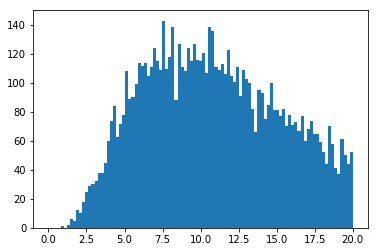

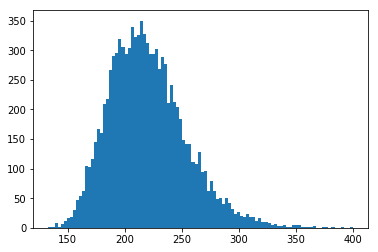

In [597]:
## So preindustrial natural emissions are:

## N2O

N=10000

PI_Nat_E = np.zeros(N)

g1 = 116 * (1 - (1+100/116)*np.exp(-100/116))
g0 = (np.sinh(116*(1-np.exp(-100/116))/g1))**(-1)

for i in np.arange(N):
    
    alpha = g0 * np.sinh(np.random.normal(N2O_params['r0'][0],N2O_params['r0'][1])/g1)
    
    PI_Nat_E[i] = 276.5 / (alpha*116*gas_params.loc['emis2conc','N2O'])
    
plt.figure()
plt.hist(PI_Nat_E,bins=np.linspace(0,20,100))

print('N2O median & stdev: ' + str(np.median(PI_Nat_E)) + ', ' + str(np.std(PI_Nat_E)))
    
## CH4    

PI_Nat_E = np.zeros(N)

g1 = 9.15 * (1 - (1+100/9.15)*np.exp(-100/9.15))
g0 = (np.sinh(9.15*(1-np.exp(-100/9.15))/g1))**(-1)

for i in np.arange(N):
    
    alpha = g0 * np.sinh(np.random.normal(CH4_params['r0'][0],CH4_params['r0'][1])/g1)
    
    PI_Nat_E[i] = 700 / (alpha*9.15*gas_params.loc['emis2conc','CH4'])
    
plt.figure()
plt.hist(PI_Nat_E,bins=100)
print('CH4 median & stdev: ' + str(np.median(PI_Nat_E)) + ', ' + str(np.std(PI_Nat_E)))

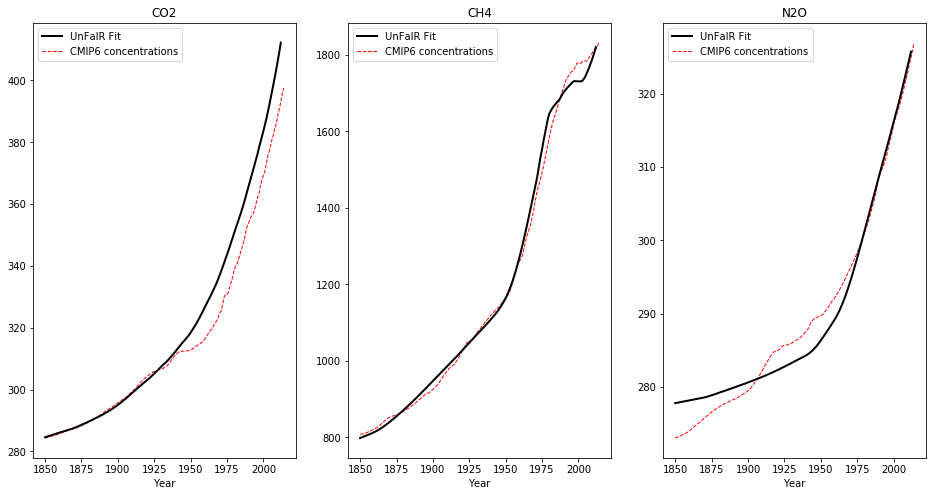

In [600]:
gas_params = default_gas_params()

gas_params.loc['r0','CH4'] = round(np.median(r0_dist_CH4),2)
gas_params.loc['PI_conc','CH4'] = round(np.median(PI_conc_dist_CH4))
gas_params.loc['rA','CH4'] = round(CH4_params['rA'][0],6)
gas_params.loc['rT','CH4'] = round(CH4_params['rT'][0],3)
gas_params.loc['r0','N2O'] = round(np.median(r0_dist_N2O),1)
gas_params.loc['PI_conc','N2O'] = round(np.median(PI_conc_dist_N2O))
gas_params.loc['rA','N2O'] = round(N2O_params['rA'][0],6)

#gas_params.loc['r0':'rT','CO2'] = [32.4,0.019,4.165]

result = UnFaIR(emissions_in=emissions,F_ext=otherforc,gas_params=gas_params)

fig,ax=plt.subplots(1,3,figsize=(16,8))
for i,s in enumerate(['CO2','CH4','N2O']):
    result['C'][s].loc[1850:].plot(ax=ax[i],label='UnFaIR Fit',linewidth=2,color='k')
    #obsv_concs[s].plot(ax=ax[i],marker='x',linewidth=0,ms=2,color='r',label='NOAA observation (atmos)')
    #Law_Dome[s].loc[1800:].plot(ax=ax[i],marker='x',linewidth=0,ms=2,color='k', label='Law Dome measurement')
    CMIP6_concs[s].loc[1850:].plot(ax=ax[i],linestyle='--',linewidth=1,ms=2,color='r',label='CMIP6 concentrations',zorder=0)
    ax[i].set_title(s)
    ax[i].set_xlabel('Year')
    ax[i].legend()
    
emissions_in = emissions.copy()
    
#for ii in np.arange(50):
#    gas_params.loc['r0','CH4'] = np.random.normal(CH4_params['r0'][0],CH4_params['r0'][1])
#    gas_params.loc['rA','CH4'] = np.random.normal(CH4_params['rA'][0],CH4_params['rA'][1])
#    gas_params.loc['rT','CH4'] = np.random.normal(CH4_params['rT'][0],CH4_params['rT'][1])
#    gas_params.loc['r0','N2O'] = np.random.normal(N2O_params['r0'][0],N2O_params['r0'][1])
#    gas_params.loc['rA','N2O'] = np.random.normal(N2O_params['rA'][0],N2O_params['rA'][1])
    
    #emissions_in['CH4'] = emissions['CH4'] * np.random.normal(1,45/352) # error from prather
    
    #emissions_in['N2O'] = emissions['N2O'] * np.random.normal(1,1.3/6.6)
    
#    result = UnFaIR(emissions_in=emissions_in,F_ext=otherforc,gas_params=gas_params)
    
#    for i,s in enumerate(['CH4','N2O']):
#        i+=1
#        result['C'][s].loc[1850:].plot(ax=ax[i],label=None,color='b',linewidth=0.1,zorder=0)
        

## Previous analysis results (normal params)
CH4
rA
0.0002585656008586544 +/- 15.04330311576293%

rT
-0.2083854104091337 +/- 13.446158053096902%

r0
9.19920423364845 +/- 11.006022828393037%

PI_conc
700.3025381749203 +/- 0.08925226237518033%

N2O
rA
-0.0007707420000000002 +/- 15.708431570566372%

r0
66.41891471489275 +/- 23.84450014837353%

PI_conc
276.417544222219 +/- 0.5930963294792136%

## Previous Results

CH4:

r0 : 9.11 [8.2116 , 10.1377]


rA : 0.000259 + / -3.89e-05


rT : -0.208 + / -0.02802


PI_conc : 700.0


N2O:
r0 : 62.8 [51.18 , 85.229]


rA : -0.000771 + / -0.00012107


PI_conc : 276.0